In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


import copy
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
import shap
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16,preprocess_input

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
W = 32 # The default size for ResNet is 224 but resize to .5 to save memory size
H = 32 # The default size for ResNet is 224 but resize to .5 to save memory size

label_to_class = {
    'MildDemented': 0,
    'ModerateDemented': 1,
    'NonDemented': 2,
    'VeryMildDemented':3
    

}
class_to_label = {v: k for k, v in label_to_class.items()}
n_classes = len(label_to_class)

def get_images(dir_name='../input/ag-alzheimer-s-dataset/AG_Alzheimer_s Dataset', label_to_class=label_to_class):
    """read images / labels from directory"""
    
    Images = []
    Classes = []
    
    for j in ['/train','/test']:
        for label_name in os.listdir(dir_name+str(j)):
            cls = label_to_class[label_name]

            for img_name in os.listdir('/'.join([dir_name+str(j), label_name])):
                img = load_img('/'.join([dir_name+str(j), label_name, img_name]), target_size=(W, H))
                img = img_to_array(img)

                Images.append(img)
                Classes.append(cls)
            
    Images = np.array(Images, dtype=np.float32)
    Classes = np.array(Classes, dtype=np.float32)
    Images, Classes = shuffle(Images, Classes, random_state=0)
    
    return Images, Classes

In [5]:
## get images / labels

Images, Classes = get_images()

Images.shape, Classes.shape

((38807, 32, 32, 3), (38807,))

In [6]:
## split train / test

indices_train, indices_test = train_test_split(list(range(Images.shape[0])), train_size=0.8, test_size=0.2, shuffle=True)

x_train = Images[indices_train]
y_train = Classes[indices_train]
x_test = Images[indices_test]
y_test = Classes[indices_test]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((31045, 32, 32, 3), (31045,), (7762, 32, 32, 3), (7762,))

In [7]:
from keras.utils import np_utils

In [8]:
y_train = keras.utils.np_utils.to_categorical(y_train, n_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, n_classes)

y_train.shape, y_test.shape

((31045, 4), (7762, 4))

In [9]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((31045, 32, 32, 3), (31045, 4), (7762, 32, 32, 3), (7762, 4))

In [10]:
pip install -U tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [12]:
num_classes = 4
input_shape = (32, 32, 3)

In [13]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((31045, 32, 32, 3), (31045, 4), (7762, 32, 32, 3), (7762, 4))

In [14]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 110
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024] 

In [15]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

2022-10-27 16:03:09.007289: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 16:03:09.008401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 16:03:09.009143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 16:03:09.010123: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [16]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [17]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


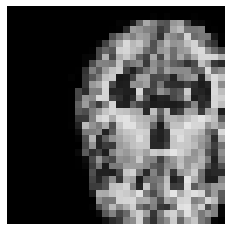

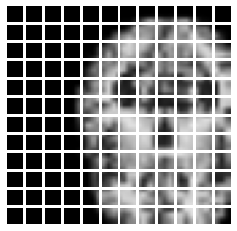

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [19]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [20]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes,activation="sigmoid")(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [21]:
    model = create_vit_classifier()
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )
    y_pred=model.predict(x_test)

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")







Epoch 1/110
110/110 [==============================] - 40s 265ms/step - loss: 2.0127 - accuracy: 0.3003 - top-5-accuracy: 1.0000 - val_loss: 1.2545 - val_accuracy: 0.4277 - val_top-5-accuracy: 1.0000
Epoch 2/110
110/110 [==============================] - 27s 248ms/step - loss: 1.2583 - accuracy: 0.3977 - top-5-accuracy: 1.0000 - val_loss: 1.0933 - val_accuracy: 0.4783 - val_top-5-accuracy: 1.0000
Epoch 3/110
110/110 [==============================] - 27s 247ms/step - loss: 1.1778 - accuracy: 0.4370 - top-5-accuracy: 1.0000 - val_loss: 1.0573 - val_accuracy: 0.4995 - val_top-5-accuracy: 1.0000
Epoch 4/110
110/110 [==============================] - 27s 248ms/step - loss: 1.1271 - accuracy: 0.4594 - top-5-accuracy: 1.0000 - val_loss: 0.9786 - val_accuracy: 0.5301 - val_top-5-accuracy: 1.0000
Epoch 5/110
110/110 [==============================] - 27s 248ms/step - loss: 1.0984 - accuracy: 0.4705 - top-5-accuracy: 1.0000 - val_loss: 1.0033 - val_accuracy: 0.5127 - val_top-5-accuracy: 1.0000


# Visualizing the training and validation accuracy vs epochs

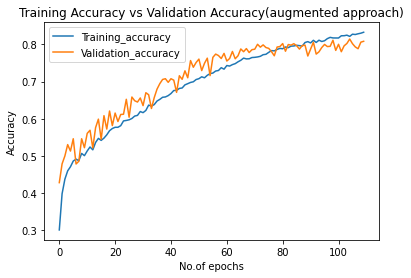

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],label='Training_accuracy')
plt.plot(history.history['val_accuracy'],label='Validation_accuracy')
plt.legend()
plt.title('Training Accuracy vs Validation Accuracy(augmented approach)')
plt.xlabel('No.of epochs')
plt.ylabel('Accuracy')
plt.show()
plt.savefig('Loss_Graph')

# Visualizing the training loss and validation loss vs epochs

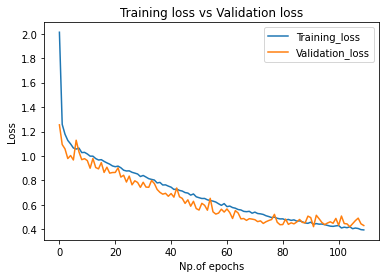

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],label='Training_loss')
plt.plot(history.history['val_loss'],label='Validation_loss')
plt.legend()
plt.title('Training loss vs Validation loss')
plt.xlabel('Np.of epochs')
plt.ylabel('Loss')
plt.show()
plt.savefig('Loss_Graph')

In [24]:
history

In [25]:

y_pred=np.argmax(model.predict(x_test), axis=1)
y_true=np.argmax(y_test, axis=1)

# Confusion Matrix

In [26]:
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix

In [27]:
cm=confusion_matrix(y_true,y_pred)

In [28]:
print(cm)

[[1706   42   18  141]
 [  63 1904    1   23]
 [ 236   45 1498  211]
 [ 437   54  204 1179]]


# Classification Report (Accuracy,precision,recall,f1 score)

In [29]:
target_names=['Mild Demented (0)','Moderate Demented (1)','Non Demented (2)','Very Mild Demented (3)']

In [30]:
print(classification_report(y_true,y_pred,target_names=target_names,digits=2))

                        precision    recall  f1-score   support

     Mild Demented (0)       0.70      0.89      0.78      1907
 Moderate Demented (1)       0.93      0.96      0.94      1991
      Non Demented (2)       0.87      0.75      0.81      1990
Very Mild Demented (3)       0.76      0.63      0.69      1874

              accuracy                           0.81      7762
             macro avg       0.81      0.81      0.81      7762
          weighted avg       0.82      0.81      0.81      7762



# Plotting the confusion matrix (2plots)

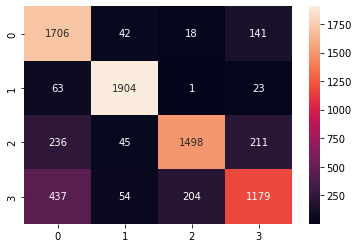

In [31]:
f = sns.heatmap(cm, annot=True, fmt='d')  #confusion matrix plot

In [32]:
plt.figure(figsize=(20,30))

<Figure size 1440x2160 with 0 Axes>

<Figure size 1440x2160 with 0 Axes>

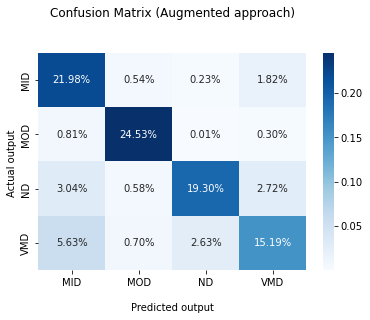

In [33]:
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix (Augmented approach)\n\n');
ax.set_xlabel('\nPredicted output')
ax.set_ylabel('Actual output ');


ax.xaxis.set_ticklabels(['MID','MOD', 'ND','VMD'])
ax.yaxis.set_ticklabels(['MID','MOD', 'ND','VMD'])
plt.show()

In [34]:
classes = ["MID", "MOD","ND","VMD"]

# Vizualising the classification report (performance of each class)

In [42]:
from sklearn.metrics import classification_report

In [43]:
clf_report = classification_report(y_true,
                                   y_pred,
                                   target_names=classes,
                                   output_dict=True)

<AxesSubplot:>

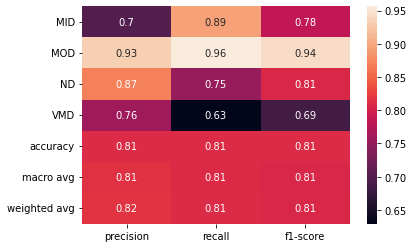

In [44]:
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)  

In [35]:
from matplotlib import pyplot
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score,cohen_kappa_score,roc_auc_score,plot_confusion_matrix,classification_report

In [36]:
accuracy = accuracy_score(y_true,y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_true, y_pred , average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true, y_pred,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true,y_pred,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.809972
Precision: 0.816786
Recall: 0.809972
F1 score: 0.807821


In [37]:
    # kappa
    kappa = cohen_kappa_score(y_true, y_pred)
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = roc_auc_score(y_test, model.predict(x_test))
    print('ROC AUC: %f' % auc)
   

Cohens kappa: 0.746610
ROC AUC: 0.949002


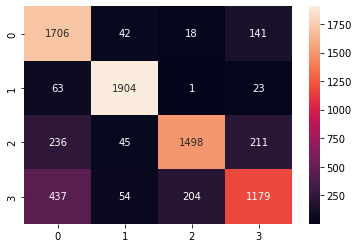

In [38]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_true, y_pred)
f = sns.heatmap(cnf_matrix, annot=True, fmt='d')

In [39]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

In [40]:
print(f'FP: {FP}' )
print(f'FN: {FN}' )
print(f'TP: {TP}' )
print(f'TN: {TN}' )

FP: [736. 141. 223. 375.]
FN: [201.  87. 492. 695.]
TP: [1706. 1904. 1498. 1179.]
TN: [5119. 5630. 5549. 5513.]


In [41]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
my_formatted_TPR = [ '%.2f' % elem for elem in TPR ]
print(f'Sensitivity: {my_formatted_TPR}') 

# Specificity or true negative rate
TNR = TN/(TN+FP) 
my_formatted_TNR = [ '%.2f' % elem for elem in TNR ]
print(f'Specificity: {my_formatted_TNR}') 

# Precision or positive predictive value
PPV = TP/(TP+FP)
my_formatted_PPV = [ '%.2f' % elem for elem in PPV ]
print(f'Precision: {my_formatted_PPV}') 
# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)
my_formatted_ACC = [ '%.2f' % elem for elem in ACC ]
print(f'accuracy: {my_formatted_ACC}')

F1 = 2 * (PPV * TPR) / (PPV + TPR)
my_formatted_F1 = [ '%.2f' % elem for elem in F1 ]
print(f'F1 Score: {my_formatted_F1}') 

print("-"*40)
sens=TPR.sum()/num_classes
spec=TNR.sum()/num_classes
f1=F1.sum()/num_classes
print(f'Sensitivity/Recall: {round(sens,2)}'  )
print(f'Specificity: {round(spec,2)}' )
print(f'F1 score: {round(f1,2)}' )

Sensitivity: ['0.89', '0.96', '0.75', '0.63']
Specificity: ['0.87', '0.98', '0.96', '0.94']
Precision: ['0.70', '0.93', '0.87', '0.76']
accuracy: ['0.88', '0.97', '0.91', '0.86']
F1 Score: ['0.78', '0.94', '0.81', '0.69']
----------------------------------------
Sensitivity/Recall: 0.81
Specificity: 0.94
F1 score: 0.81


In [50]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
classes = num_classes
roc_auc_ovr = {}
for i in range(len(classes)):
    # Gets the class
    c = classes_to_label[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 3, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 3, i+4)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()

TypeError: object of type 'int' has no len()

<Figure size 864x576 with 0 Axes>